In [2]:
!pip install -e .. sympy numpy matplotlib seaborn -q # Install dev version of smolagents + some packages


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import datasets
import pandas as pd

eval_ds = datasets.load_dataset("m-ric/smolagentsbenchmark")["train"]
pd.DataFrame(eval_ds)

/Users/aymeric/venv/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since m-ric/smolagentsbenchmark couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/aymeric/.cache/huggingface/datasets/m-ric___smolagentsbenchmark/default/0.0.0/0ad5fb2293ab185eece723a4ac0e4a7188f71add (last modified on Wed Jan  8 17:50:13 2025).


,question,source,true_answer,true_reasoning
0,If Eliud Kipchoge could maintain his record-ma...,GAIA,17,None
1,How many studio albums were published by Merce...,GAIA,3,None
2,Here's a fun riddle that I think you'll enjoy....,GAIA,3,None
3,"My family reunion is this week, and I was assi...",GAIA,2,None
4,In Emily Midkiff's June 2014 article in a jour...,GAIA,fluffy,None
...,...,...,...,...
127,"What year was the municipality of San Carlos, ...",SimpleQA,1786,"['https://en.wikipedia.org/wiki/San_Carlos,_An..."
128,In which year was Maria Elena Walsh named Illu...,SimpleQA,1985,['https://en.wikipedia.org/wiki/Mar%C3%ADa_Ele...
129,What is the durability of the Istarelle spear ...,SimpleQA,800,"['http://demonssouls.wikidot.com/spear', 'http..."
130,What is the number of the executive order that...,SimpleQA,7034,['https://www.loc.gov/collections/federal-thea...


### Define utilities and tools
To run the SERPAPI tool, you will need to have a [SerpAPI](https://serpapi.com/dashboard) API key: for this you need a paid account.

In [2]:
import time
import json
import os
import re
import string
import warnings
from tqdm import tqdm
from typing import List

from smolagents import (
    GoogleSearchTool,
    CodeAgent,
    ToolCallingAgent,
    HfApiModel,
    AgentError,
    VisitWebpageTool,
    PythonInterpreterTool,
)
from smolagents.agents import ActionStep
from dotenv import load_dotenv

load_dotenv()
os.makedirs("output", exist_ok=True)


def serialize_agent_error(obj):
    if isinstance(obj, AgentError):
        return {"error_type": obj.__class__.__name__, "message": obj.message}
    else:
        return str(obj)


def answer_questions(
    eval_ds, file_name, agent, model_id, action_type, is_vanilla_llm=False
):
    answered_questions = []
    if os.path.exists(file_name):
        with open(file_name, "r") as f:
            for line in f:
                answered_questions.append(json.loads(line)["question"])

    for _, example in tqdm(enumerate(eval_ds), total=len(eval_ds)):
        try:
            question = example["question"]
            if example["source"] == "SimpleQA":
                question += " Answer with only the final number."
            if example["source"] == "MATH":
                question += " Write code, not latex."
            if question in answered_questions:
                continue
            start_time = time.time()

            if is_vanilla_llm:
                llm = agent
                answer = llm([{"role": "user", "content": question}])
                token_count = llm.last_input_token_count + llm.last_output_token_count
                intermediate_steps = []
            else:
                answer = agent.run(question)
                token_count = agent.monitor.get_total_token_counts()
                intermediate_steps = str(agent.logs)
                # Remove memory from logs to make them more compact.
                for step in agent.logs:
                    if isinstance(step, ActionStep):
                        step.agent_memory = None

            end_time = time.time()
            annotated_example = {
                "model_id": model_id,
                "agent_action_type": action_type,
                "question": question,
                "answer": answer,
                "true_answer": example["true_answer"],
                "source": example["source"],
                "intermediate_steps": intermediate_steps,
                "start_time": start_time,
                "end_time": end_time,
                "token_counts": token_count,
            }

            with open(file_name, "a") as f:
                json.dump(annotated_example, f, default=serialize_agent_error)
                f.write("\n")  # add a newline for JSONL format
        except Exception as e:
            print("Failed:", e)


def normalize_number_str(number_str: str) -> float:
    # we replace these common units and commas to allow
    # conversion to float
    for char in ["$", "%", ","]:
        number_str = number_str.replace(char, "")
    try:
        return float(number_str)
    except ValueError:
        return float("inf")


def split_string(
    s: str,
    char_list: list[str] = [",", ";"],
) -> list[str]:
    pattern = f"[{''.join(char_list)}]"
    return re.split(pattern, s)


def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False


def normalize_str(input_str, remove_punct=True) -> str:
    """
    Normalize a string by:
    - Removing all white spaces
    - Optionally removing punctuation (if remove_punct is True)
    - Converting to lowercase
    Parameters:
    - input_str: str, the string to normalize
    - remove_punct: bool, whether to remove punctuation (default: True)
    Returns:
    - str, the normalized string
    """
    # Remove all white spaces. Required e.g for seagull vs. sea gull
    no_spaces = re.sub(r"\s", "", input_str)

    # Remove punctuation, if specified.
    if remove_punct:
        translator = str.maketrans("", "", string.punctuation)
        return no_spaces.lower().translate(translator)
    else:
        return no_spaces.lower()


def extract_numbers(text: str) -> List[str]:
    """This pattern matches:
    - Optional negative sign
    - Numbers with optional comma thousand separators
    - Optional decimal points with decimal numbers
    """
    pattern = r"-?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?"

    return [el.replace(",", "") for el in re.findall(pattern, text)]


def get_question_score_gaia(
    model_answer: str,
    ground_truth: str,
) -> bool:
    if is_float(ground_truth):
        normalized_answer = normalize_number_str(str(model_answer))
        return normalized_answer == float(ground_truth)

    elif any(char in ground_truth for char in [",", ";"]):  # if gt is a list
        # question with the fish: normalization removes punct
        gt_elems = split_string(ground_truth)
        ma_elems = split_string(model_answer)

        if len(gt_elems) != len(ma_elems):  # check length is the same
            warnings.warn(
                "Answer lists have different lengths, returning False.", UserWarning
            )
            return False

        comparisons = []
        for ma_elem, gt_elem in zip(
            ma_elems, gt_elems
        ):  # compare each element as float or str
            if is_float(gt_elem):
                normalized_ma_elem = normalize_number_str(ma_elem)
                comparisons.append(normalized_ma_elem == float(gt_elem))
            else:
                # we do not remove punct since comparisons can include punct
                comparisons.append(
                    normalize_str(ma_elem, remove_punct=False)
                    == normalize_str(gt_elem, remove_punct=False)
                )
        return all(comparisons)

    else:  # if gt is a str
        return normalize_str(model_answer) == normalize_str(ground_truth)

## Benchmark agents

### Open models

In [ ]:
open_model_ids = [
    "meta-llama/Llama-3.3-70B-Instruct",
    # "Qwen/QwQ-32B-Preview",
    "Qwen/Qwen2.5-72B-Instruct",
    "Qwen/Qwen2.5-Coder-32B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    # "meta-llama/Llama-3.1-70B-Instruct",
]

for model_id in open_model_ids:
    print(f"Evaluating '{model_id}'...")
    # action_type = "tool_calling"
    # agent = ToolCallingAgent(
    #     tools=[GoogleSearchTool(), VisitWebpageTool(), PythonInterpreterTool()],
    #     model=HfApiModel(model_id),
    #     max_steps=10,
    # )
    # file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    # answer_questions(eval_ds, file_name, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        model=HfApiModel(model_id),
        additional_authorized_imports=["numpy", "sympy"],
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = HfApiModel(model_id)
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(
        eval_ds, file_name, llm, model_id, action_type, is_vanilla_llm=True
    )

Evaluating 'meta-llama/Llama-3.3-70B-Instruct'...


 16%|█▌        | 21/132 [02:18<07:35,  4.11s/it]

## Closed models

In [ ]:
from smolagents import LiteLLMModel

litellm_model_ids = ["gpt-4o", "anthropic/claude-3-5-sonnet-latest"]

for model_id in litellm_model_ids:
    print(f"Evaluating '{model_id}'...")
    action_type = "tool_calling"
    agent = ToolCallingAgent(
        tools=[
            GoogleSearchTool(),
            VisitWebpageTool(),
            PythonInterpreterTool(["numpy", "sympy"]),
        ],
        model=LiteLLMModel(model_id),
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        model=LiteLLMModel(model_id),
        additional_authorized_imports=["numpy"],
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = LiteLLMModel(model_id)
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(
        eval_ds, file_name, llm, model_id, action_type, is_vanilla_llm=True
    )

In [5]:
# import glob
# import json
# jsonl_files = glob.glob(f"output/*.jsonl")

# for file_path in jsonl_files:
#     print(file_path)
#     # Read all lines and filter out SimpleQA sources
#     filtered_lines = []
#     removed = 0
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             try:
#                 data = json.loads(line.strip())
#                 if not any([question in data["question"] for question in eval_ds["question"]]):
#                     removed +=1
#                 else:
#                     filtered_lines.append(line)
#             except json.JSONDecodeError:
#                 print("Invalid line:", line)
#                 continue  # Skip invalid JSON lines
#     print(f"Removed {removed} lines.")
#     # Write filtered content back to the same file
#     with open(file_path, 'w', encoding='utf-8') as f:
#         f.writelines(filtered_lines)

## Score answers

In [ ]:
import pandas as pd
import glob

res = []
for f in glob.glob("output/*.jsonl"):
    res.append(pd.read_json(f, lines=True))
result_df = pd.concat(res)


def get_correct(row):
    if row["source"] == "MATH":  # Checks the last number in answer
        numbers_answer = extract_numbers(str(row["answer"]))
        if len(numbers_answer) == 0:
            return False
        return float(numbers_answer[-1]) == float(row["true_answer"])
    else:
        return get_question_score_gaia(str(row["answer"]), str(row["true_answer"]))


result_df["correct"] = result_df.apply(get_correct, axis=1)

result_df = result_df.loc[
    (result_df["agent_action_type"] == "code")
    & (
        ~result_df["model_id"].isin(
            [
                "meta-llama/Llama-3.2-3B-Instruct",
                "meta-llama/Llama-3.1-70B-Instruct",
                "HuggingFaceTB/SmolLM2-1.7B-Instruct",
            ]
        )
    )
]
result_df = (
    (result_df.groupby(["model_id", "source"])[["correct"]].mean() * 100)
    .round(1)
    .reset_index()
)
result_df["type"] = "agent"

/var/folders/6m/9b1tts6d5w960j80wbw9tx3m0000gn/T/ipykernel_42622/3624585289.py:156: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn(


In [7]:
pivot_df = result_df.pivot_table(
    index=["model_id", "source"],
    columns=["type"],
    values="correct",
    fill_value=float("nan"),
).reset_index()

### Display results

In [9]:
display(pivot_df)

type,model_id,source,agent,vanilla
0,Qwen/Qwen2.5-72B-Instruct,GAIA,28.1,NaN
1,Qwen/Qwen2.5-72B-Instruct,MATH,74.0,NaN
2,Qwen/Qwen2.5-72B-Instruct,SimpleQA,70.0,9.1
3,Qwen/Qwen2.5-Coder-32B-Instruct,GAIA,18.8,NaN
4,Qwen/Qwen2.5-Coder-32B-Instruct,MATH,76.0,30.6
5,Qwen/Qwen2.5-Coder-32B-Instruct,SimpleQA,86.0,NaN
6,anthropic/claude-3-5-sonnet-latest,GAIA,53.1,NaN
8,anthropic/claude-3-5-sonnet-latest,MATH,72.0,NaN
9,anthropic/claude-3-5-sonnet-latest,SimpleQA,92.0,28.4
10,gpt-4o,GAIA,34.4,9.3


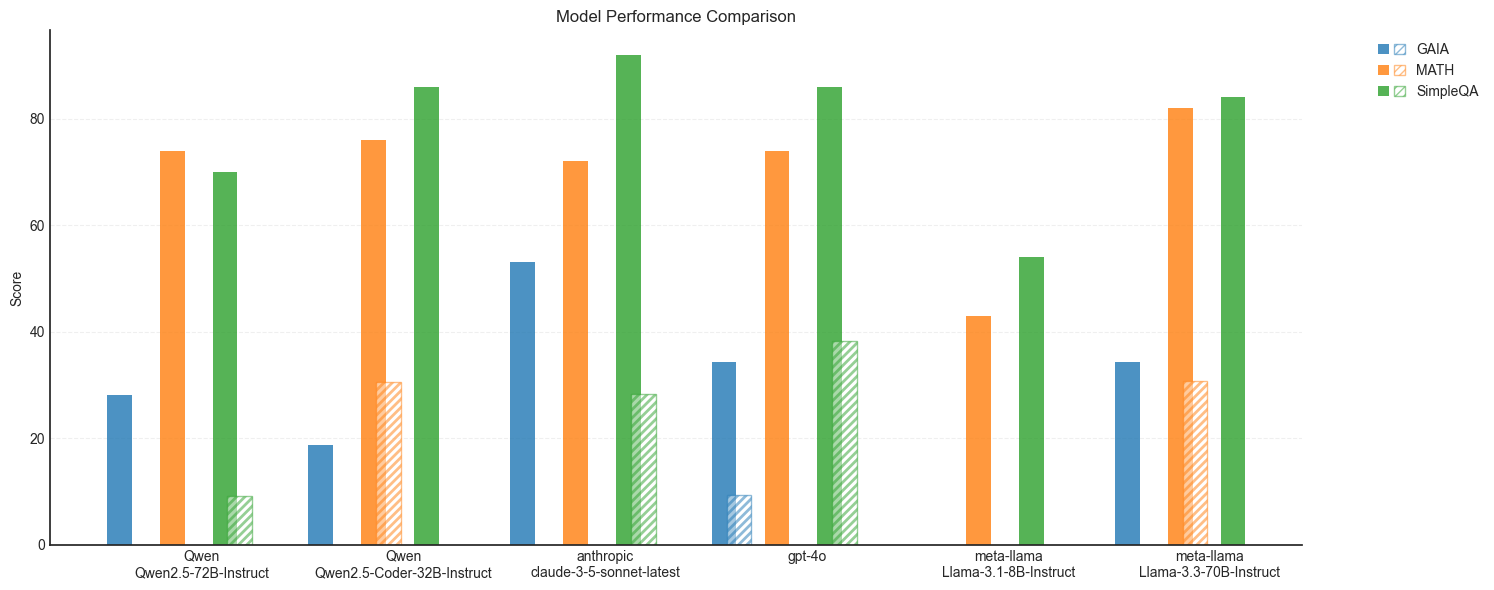

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerTuple  # Added import

# Assuming pivot_df is your original dataframe
models = pivot_df["model_id"].unique()
sources = pivot_df["source"].unique()

# Create figure and axis
plt.style.use("seaborn-v0_8-white")
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of each bar group and positions of the bars
width = 0.15  # width of each bar
spacing = 0.02  # space between bars within a group
group_spacing = 0.2  # space between model groups

# Calculate positions for the bars
num_sources = len(sources)
total_width_per_group = (width + spacing) * num_sources * 2  # *2 for agent and vanilla
x = np.arange(len(models)) * (total_width_per_group + group_spacing)

# Plot bars for each source
for i, source in enumerate(sources):
    source_data = pivot_df[pivot_df["source"] == source]
    agent_scores = [
        source_data[source_data["model_id"] == model]["agent"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]
    vanilla_scores = [
        source_data[source_data["model_id"] == model]["vanilla"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]

    # Position calculation for each pair of bars
    pos = x + i * (width * 2 + spacing)

    agent_bars = ax.bar(pos, agent_scores, width, label=f"{source} (Agent)", alpha=0.8)
    vanilla_bars = ax.bar(
        pos + width * 0.6,
        vanilla_scores,
        width,
        hatch="////",
        alpha=0.5,
        hatch_linewidth=2,
        label=f"{source} (Vanilla)",
        color="white",
        edgecolor=agent_bars[0].get_facecolor(),
    )

# Customize the plot
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")

# Set x-axis ticks in the middle of each group
group_centers = x + (total_width_per_group - spacing) / 2
ax.set_xticks(group_centers)

# Wrap long model names to prevent overlap
wrapped_labels = ["\n".join(model.split("/")) for model in models]
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Modify legend to combine agent and vanilla entries
handles, labels = ax.get_legend_handles_labels()
unique_sources = sources
legend_elements = [
    (handles[i * 2], handles[i * 2 + 1], labels[i * 2].replace(" (Agent)", ""))
    for i in range(len(unique_sources))
]
custom_legend = ax.legend(
    [
        (agent_handle, vanilla_handle)
        for agent_handle, vanilla_handle, _ in legend_elements
    ],
    [label for _, _, label in legend_elements],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [12]:
def create_mathjax_table(pivot_df, formatted_df):
    # Start the matrix environment with 4 columns
    # l for left-aligned model and task, c for centered numbers
    mathjax_table = "\\begin{array}{llcc}\n"
    mathjax_table += (
        "\\text{Model} & \\text{Task} & \\text{Agent} & \\text{Vanilla} \\\\\n"
    )
    mathjax_table += "\\hline\n"

    # Sort the DataFrame by model_id and source
    formatted_df = formatted_df.sort_values(["model_id", "source"])

    current_model = None
    for _, row in formatted_df.iterrows():
        model = row["model_id"]
        source = row["source"]

        # Add a horizontal line between different models
        if current_model is not None and current_model != model:
            mathjax_table += "\\hline\n"

        # Format model name
        model_display = model.replace("_", "\\_")
        if "Qwen" in model or "anthropic" in model:
            model_display = f"\\textit{{{model_display}}}"

        # If it's the same model as previous row, use empty space
        if current_model == model:
            model_display = "\\;"

        # Add the data row
        mathjax_table += (
            f"{model_display} & {source} & {row['agent']} & {row['vanilla']} \\\\\n"
        )

        current_model = model

    mathjax_table += "\\hline\n"
    mathjax_table += "\\end{array}"

    return mathjax_table


# Usage (after running your previous data processing code):
mathjax_table = create_mathjax_table(pivot_df, formatted_df)
print(mathjax_table)

NameError: name 'formatted_df' is not defined